In [2]:
""" CIND820 Project  
Sales forecasting using various methods just as XGboost and SARIMA
Dataset from - https://archive.ics.uci.edu/ml/datasets/online+retail
"""
import pandas as pd
import numpy as np
import os
from pandas_profiling import ProfileReport
from matplotlib import pyplot

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

In [ ]:
# pathDir = os.getcwd()
# fileName = "Online Retail.xlsx"
# pathFile = "{}{}{}".format(pathDir,os.sep,fileName)
# pathFile
# df = pd.read_excel(pathFile)

In [34]:
#Use this to look at the items with the highest counts to use in our data
df['Description'].value_counts()


WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

In [4]:
profile = ProfileReport(df)
profile.to_widgets()

In [5]:
df.describe(include=object)

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


In [6]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
#Select items to use in dataset, will use the 5 items with the most units purchased
filterItems = ["WHITE HANGING HEART T-LIGHT HOLDER","REGENCY CAKESTAND 3 TIER","JUMBO BAG RED RETROSPOT","PARTY BUNTING","LUNCH BAG RED RETROSPOT"]
df = df[df["Description"].isin(filterItems)]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850.0,United Kingdom
93,536378,20725,LUNCH BAG RED RETROSPOT,10,2010-12-01 09:37:00,1.65,14688.0,United Kingdom
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 09:57:00,1.65,16029.0,United Kingdom
...,...,...,...,...,...,...,...,...
541290,581497,22423,REGENCY CAKESTAND 3 TIER,8,2011-12-09 10:23:00,24.96,NaN,United Kingdom
541318,581497,47566,PARTY BUNTING,5,2011-12-09 10:23:00,10.79,NaN,United Kingdom
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541696,581538,20725,LUNCH BAG RED RETROSPOT,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom


In [5]:
#This sums all the quantities of a particular item that was purchased in a day
df2 = df.groupby(['Description', pd.Grouper(key='InvoiceDate', freq='D',label='left')])['Quantity'].sum().reset_index()
df2


,Description,InvoiceDate,Quantity
0,JUMBO BAG RED RETROSPOT,2010-12-01,556
1,JUMBO BAG RED RETROSPOT,2010-12-02,48
2,JUMBO BAG RED RETROSPOT,2010-12-03,49
3,JUMBO BAG RED RETROSPOT,2010-12-05,39
4,JUMBO BAG RED RETROSPOT,2010-12-06,157
...,...,...,...
1497,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-04,8
1498,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-05,313
1499,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-06,38
1500,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-07,202


In [6]:
#Changing items to its own column using unstack
#Using method found in https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns
#df3 = df2.groupby(["InvoiceDate","Description"])["Quantity"].aggregate("first").unstack().fillna(0)
#df3

#Changing items to its own column using pivot
#Filling the NA values with 0 since they occur because there are no sales on that day for that particular item
df3 = df2.pivot(index="InvoiceDate", columns = "Description", values="Quantity").fillna(0)
df3

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
InvoiceDate,,,,,
2010-12-01,556.0,78.0,0.0,115.0,454.0
2010-12-02,48.0,11.0,0.0,184.0,309.0
2010-12-03,49.0,93.0,11.0,231.0,60.0
2010-12-05,39.0,36.0,8.0,92.0,198.0
2010-12-06,157.0,34.0,17.0,155.0,161.0
...,...,...,...,...,...
2011-12-05,66.0,50.0,16.0,36.0,313.0
2011-12-06,175.0,85.0,21.0,160.0,38.0
2011-12-07,85.0,35.0,3.0,130.0,202.0


In [ ]:
dateRange = pd.date_range(min(df3.index),max(df3.index))
df4 = df3.reindex(dateRange,fill_value=0)
df4

In [41]:
profile = ProfileReport(df4)
profile.to_widgets()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

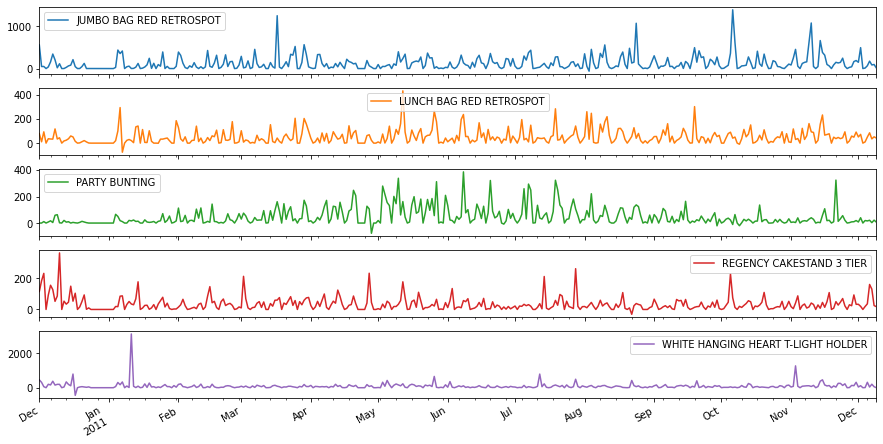

In [42]:
df4.plot(subplots=True, figsize=(15,8))


In [40]:
dateRange = pd.date_range(min(df3.index),max(df3.index))
df4 = df3.reindex(dateRange,fill_value=0)
df4

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
2010-12-01,556.0,78.0,0.0,115.0,454.0
2010-12-02,48.0,11.0,0.0,184.0,309.0
2010-12-03,49.0,93.0,11.0,231.0,60.0
2010-12-04,0.0,0.0,0.0,0.0,0.0
2010-12-05,39.0,36.0,8.0,92.0,198.0
...,...,...,...,...,...
2011-12-05,66.0,50.0,16.0,36.0,313.0
2011-12-06,175.0,85.0,21.0,160.0,38.0
2011-12-07,85.0,35.0,3.0,130.0,202.0
2011-12-08,96.0,52.0,22.0,25.0,58.0


In [47]:
df4.describe()

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
count,374.000000,374.000000,374.000000,374.000000,374.000000
mean,126.639037,50.211230,48.187166,34.847594,94.430481
std,175.472799,60.059227,67.854380,45.104892,200.447005
min,-62.000000,-75.000000,-77.000000,-31.000000,-442.000000
25%,10.250000,5.250000,3.250000,5.000000,15.000000
50%,62.000000,35.000000,21.000000,21.000000,57.500000
75%,161.000000,66.750000,66.000000,48.750000,115.500000
max,1385.000000,431.000000,386.000000,362.000000,3113.000000
